In [1]:
%load_ext autoreload
%autoreload 2

In [24]:
from argparse import Namespace
from pathlib import Path
import torch
from pytorch_lightning.trainer import Trainer, seed_everything
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

from turboflow.dataloaders import TurboFlowDataModule
from turboflow.evaluation import compute_all_metrics

from turboflow.utils import phy_utils as phy
from turboflow.utils import torch_utils as tch
from turboflow.utils import file_utils as fle

import matplotlib.pyplot as plt

import pandas as pd
import yaml

import seaborn as sns

from natsort import natsorted

In [28]:
# load dataset
data_dir = Path('/','home','dicarlo_d','Documents','Datasets','Turb2D.hdf5')
dm = TurboFlowDataModule(dataset='Turb2D', 
                         data_dir=data_dir,
                         batch_size=100000,
                         time_idx=0,
                         train_downsampling=8,
                         val_downsampling=4,
                         test_downsampling=1,
                         num_workers=1)
dm.setup()


X_lr, y_lr = dm.train_dataset[:]
img_shape_lr = dm.train_dataset.img_shape[:2]
shape_lr = dm.train_dataset.img_shape
L = shape_lr[0]
N_lr = X_lr.shape[0]
print(N_lr, L)

X_mr, y_mr = dm.val_dataset[:]
img_shape_mr = dm.val_dataset.img_shape[:2]
shape_mr = dm.val_dataset.img_shape
M = shape_mr[0]
N_mr = X_mr.shape[0]
print(N_mr, M)

X_hr, y_hr = dm.test_dataset[:]
img_shape_hr = dm.test_dataset.img_shape[:2]
shape_hr = dm.test_dataset.img_shape
H = shape_hr[0]
N_hr = X_hr.shape[0]
print(N_hr, H)

dsets_dict = {}

dsets = {
    'train' : dm.train_dataset,
    'val' : dm.val_dataset,
    'test' : dm.test_dataset
}

for stage in dsets.keys():
    tmp = {}
    
    dset = dsets[stage]
    X, y = dset[:]
    img_shape = dset.img_shape[:2]
    shape = dset.img_shape
    R = shape[0]
    
    print(stage, X.shape, y.shape, R)
    
    tmp['X'] = X
    tmp['y'] = y
    tmp['R'] = R
    tmp['img_shape'] = img_shape
    
    dsets_dict[stage] = tmp

1024 32
4096 64
65536 256
train torch.Size([1024, 2]) torch.Size([1024, 2]) 32
val torch.Size([4096, 2]) torch.Size([4096, 2]) 64
test torch.Size([65536, 2]) torch.Size([65536, 2]) 256


In [63]:
results_dir = Path('..','recipes','turbo2D','single_images','results')
results_paths = list([str(i) for i in results_dir.glob('*')])

df = pd.DataFrame()

c = 0
for path in results_paths:
    
    path = Path(path)
    results_dict = fle.load_obj(path)
    
    df.at[c, 'name'] = results_dict['hparams']['name']
    df.at[c, 'version'] = results_dict['pl_version']
    df.at[c, 'success'] = results_dict['success']
    
    for field in ['mlp_layers_num','rff_num','lam_sdiv','lam_curl','lam_grads', 'lam_sfn', 'lam_weight']:
        df.at[c, field] = results_dict['hparams'][field]
    
    df.at[c, 'rec'] = results_dict['test_metrics'][0]['test/metrics/reconstruction']
    df.at[c, 'spc'] = results_dict['test_metrics'][0]['test/metrics/log_err_specturm']
    df.at[c, 'ang'] = results_dict['test_metrics'][0]['test/metrics/angular_degree']
    
    df.at[c, 'model_path'] = results_dict['path_to_best_model']
    
    c += 1
    
df.to_csv(results_dir / Path('../results.csv'))

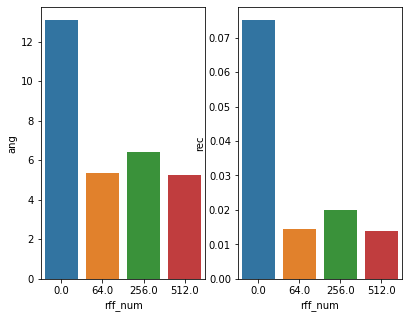

Int64Index([57, 67, 75, 83], dtype='int64')


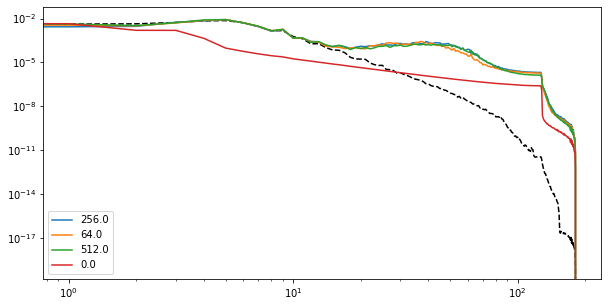

In [36]:
curr_df = df.loc[
                (df['lam_sdiv'] == 0) &
                (df['lam_grads'] == 0) &
                (df['lam_curl'] == 0) &
                (df['lam_sfn'] == 0)
]

plt.figure(figsize=(10,5))
plt.subplot(131)
sns.barplot(x='rff_num', y='ang',data=curr_df)
plt.subplot(132)
sns.barplot(x='rff_num', y='rec',data=curr_df)
plt.show()

print(curr_df.index)

spec_gt = phy.energy_spectrum(y_hr.view(H,H,2).permute(2,0,1))[0]
plt.figure(figsize=(10,5))
plt.loglog(spec_gt.detach(), 'k--')

for r, row in curr_df.iterrows():    
    
    model_path = row['model_path']
    rff_num = row['rff_num']
    
    from turboflow.models.phyrff_hard import plDivFreeRFFNet
    model = plDivFreeRFFNet.load_from_checkpoint(model_path)
    
    y_hat = model(X_hr)[0]
    
    spec = phy.energy_spectrum(y_hat.view(H,H,2).permute(2,0,1))[0]
    plt.loglog(spec.detach().cpu().numpy(), label=f'{rff_num}')

    
plt.legend()
plt.show()

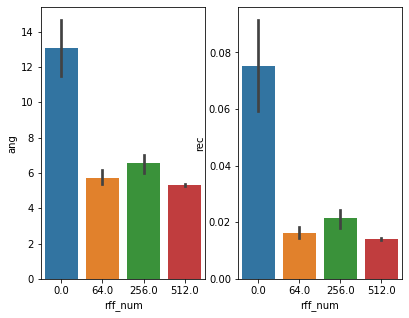

Int64Index([13, 18, 21, 57, 67, 69, 73, 75, 83, 88, 90], dtype='int64')


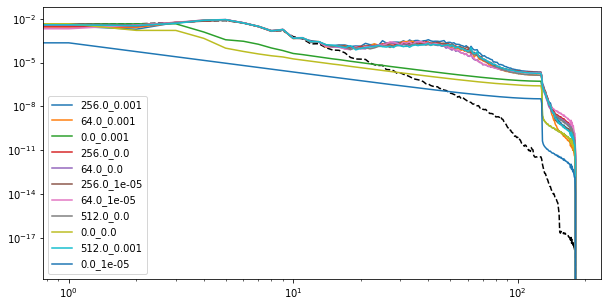

In [37]:
curr_df = df.loc[
                (df['lam_grads'] == 0) &
                (df['lam_curl'] == 0) &
                (df['lam_sfn'] == 0)
]

plt.figure(figsize=(10,5))
plt.subplot(131)
sns.barplot(x='rff_num', y='ang',data=curr_df)
plt.subplot(132)
sns.barplot(x='rff_num', y='rec',data=curr_df)
plt.show()

print(curr_df.index)

spec_gt = phy.energy_spectrum(y_hr.view(H,H,2).permute(2,0,1))[0]
plt.figure(figsize=(10,5))
plt.loglog(spec_gt.detach(), 'k--')

for r, row in curr_df.iterrows():    
    
    model_path = row['model_path']
    rff_num = row['rff_num']
    lam_sdiv = row['lam_sdiv']
    
    from turboflow.models.phyrff_hard import plDivFreeRFFNet
    model = plDivFreeRFFNet.load_from_checkpoint(model_path)
    
    y_hat = model(X_hr)[0]
    
    spec = phy.energy_spectrum(y_hat.view(H,H,2).permute(2,0,1))[0]
    plt.loglog(spec.detach().cpu().numpy(), label=f'{rff_num}_{lam_sdiv}')

    
plt.legend()
plt.show()

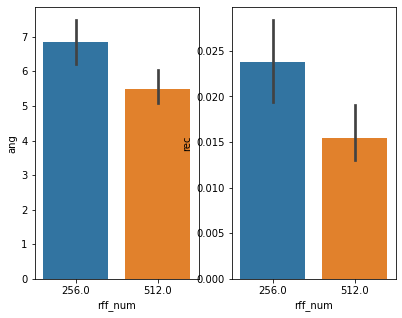

Int64Index([9, 13, 19, 25, 27, 42, 43, 48, 53, 57, 66, 69, 75, 87, 88], dtype='int64')


,name,version,success,mlp_layers_num,rff_num,lam_sdiv,lam_curl,lam_grads,lam_sfn,lam_weight,rec,spc,ang,model_path
9,RFFMLP_run:8-ds:4-mlp:3-rff_num:256-df:true-ls...,version_70,True,3.0,256.0,0.00100,0.0,1.000000e-05,0.0,0.0001,0.029456,128.751617,7.570065,/home/dicarlo_d/Documents/Code/TurboSuperResul...
13,RFFMLP_run:8-ds:4-mlp:3-rff_num:256-df:true-ls...,version_64,True,3.0,256.0,0.00100,0.0,0.000000e+00,0.0,0.0001,0.026558,120.827332,7.345861,/home/dicarlo_d/Documents/Code/TurboSuperResul...
19,RFFMLP_run:8-ds:4-mlp:3-rff_num:512-df:true-ls...,version_94,True,3.0,512.0,0.00100,0.0,1.000000e-08,0.0,0.0001,0.012538,121.164856,4.997313,/home/dicarlo_d/Documents/Code/TurboSuperResul...
25,RFFMLP_run:8-ds:4-mlp:3-rff_num:256-df:true-ls...,version_58,True,3.0,256.0,0.00000,0.0,1.000000e-08,0.0,0.0001,0.035819,126.742897,8.469627,/home/dicarlo_d/Documents/Code/TurboSuperResul...
27,RFFMLP_run:8-ds:4-mlp:3-rff_num:256-df:true-ls...,version_61,True,3.0,256.0,0.00000,0.0,1.000000e-05,0.0,0.0001,0.019019,126.797447,6.260316,/home/dicarlo_d/Documents/Code/TurboSuperResul...
42,RFFMLP_run:8-ds:4-mlp:3-rff_num:512-df:true-ls...,version_97,True,3.0,512.0,0.00100,0.0,1.000000e-05,0.0,0.0001,0.012428,121.716782,4.986285,/home/dicarlo_d/Documents/Code/TurboSuperResul...
43,RFFMLP_run:8-ds:4-mlp:3-rff_num:256-df:true-ls...,version_79,True,3.0,256.0,0.00001,0.0,1.000000e-05,0.0,0.0001,0.012979,121.415939,5.100121,/home/dicarlo_d/Documents/Code/TurboSuperResul...
48,RFFMLP_run:8-ds:4-mlp:3-rff_num:256-df:true-ls...,version_76,True,3.0,256.0,0.00001,0.0,1.000000e-08,0.0,0.0001,0.030023,120.947441,7.732529,/home/dicarlo_d/Documents/Code/TurboSuperResul...
53,RFFMLP_run:8-ds:4-mlp:3-rff_num:256-df:true-ls...,version_67,True,3.0,256.0,0.00100,0.0,1.000000e-08,0.0,0.0001,0.021857,123.832436,6.753746,/home/dicarlo_d/Documents/Code/TurboSuperResul...
57,RFFMLP_run:8-ds:4-mlp:3-rff_num:256-df:true-ls...,version_55,True,3.0,256.0,0.00000,0.0,0.000000e+00,0.0,0.0001,0.019919,122.591080,6.406679,/home/dicarlo_d/Documents/Code/TurboSuperResul...


In [49]:
curr_df = df.loc[
                (df['rff_num'] >= 256) &
                (df['lam_curl'] == 0) &
                (df['lam_sfn'] == 0)
]

plt.figure(figsize=(10,5))
plt.subplot(131)
sns.barplot(x='rff_num', y='ang',data=curr_df)
plt.subplot(132)
sns.barplot(x='rff_num', y='rec',data=curr_df)
plt.show()

print(curr_df.index)
curr_df

KeyboardInterrupt: 

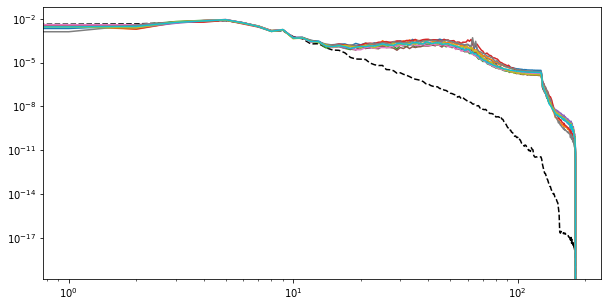

In [50]:
spec_gt = phy.energy_spectrum(y_hr.view(H,H,2).permute(2,0,1))[0]
plt.figure(figsize=(10,5))
plt.loglog(spec_gt.detach(), 'k--')

for r, row in curr_df.iterrows():    
    
    model_path = row['model_path']
    rff_num = row['rff_num']
    lam_sdiv = row['lam_sdiv']
    
    from turboflow.models.phyrff_hard import plDivFreeRFFNet
    model = plDivFreeRFFNet.load_from_checkpoint(model_path)
    
    y_hat = model(X_hr)[0]
    
    spec = phy.energy_spectrum(y_hat.view(H,H,2).permute(2,0,1))[0]
    plt.loglog(spec.detach().cpu().numpy(), label=f'{rff_num}_{lam_sdiv}')

plt.tight_layout()
plt.legend()
plt.show()

<AxesSubplot:xlabel='rff_num', ylabel='ang'>

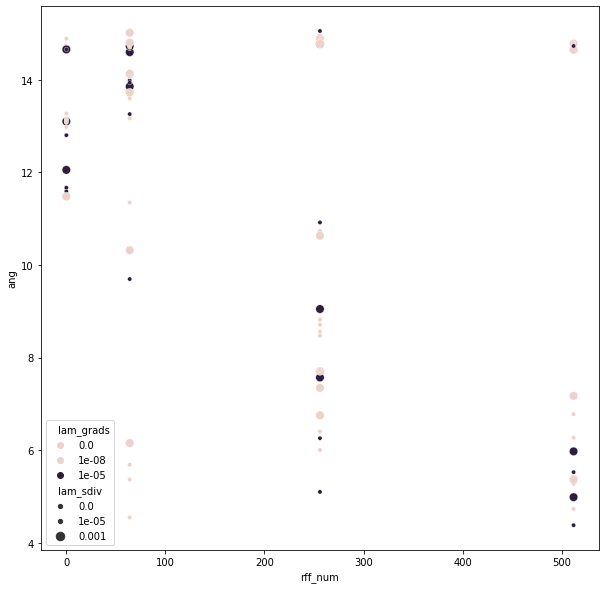

In [60]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='rff_num', y='ang', hue='lam_grads', data=df, size='lam_sdiv')

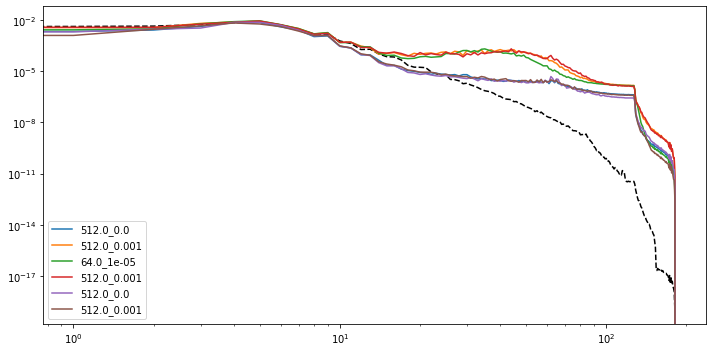

In [64]:
spec_gt = phy.energy_spectrum(y_hr.view(H,H,2).permute(2,0,1))[0]
plt.figure(figsize=(10,5))
plt.loglog(spec_gt.detach(), 'k--')

for r, row in df.iterrows():    
    
    if r not in [8, 23, 70, 42, 19, 79]:
        continue
    
    model_path = row['model_path']
    rff_num = row['rff_num']
    lam_sdiv = row['lam_sdiv']
    
    from turboflow.models.phyrff_hard import plDivFreeRFFNet
    model = plDivFreeRFFNet.load_from_checkpoint(model_path)
    
    y_hat = model(X_hr)[0]
    
    spec = phy.energy_spectrum(y_hat.view(H,H,2).permute(2,0,1))[0]
    plt.loglog(spec.detach().cpu().numpy(), label=f'{rff_num}_{lam_sdiv}')

plt.tight_layout()
plt.legend()
plt.show()